In [1]:
import datetime as dt

import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential

In [2]:
# Load the dataset (using yfinance)
data = yf.download('AAPL', start='2018-01-01', end=dt.date.today())

[*********************100%***********************]  1 of 1 completed


In [3]:
# Calculate additional technical indicators
data['MACD'] = data['Close'].ewm(span=12, adjust=False).mean() - data['Close'].ewm(span=26, adjust=False).mean()
data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()
data['MACD_diff'] = data['MACD'] - data['Signal_Line']

window_length = 14
delta = data['Close'].diff(1)
delta = delta[1:]
up, down = delta.copy(), delta.copy()
up[up < 0] = 0
down[down > 0] = 0
data['RSI'] = 100 - (100 / (1 + (up.rolling(window_length).mean() / down.abs().rolling(window_length).mean())))

# Calculate Simple Moving Averages (SMA)
data['SMA_20'] = data['Close'].rolling(window=20).mean()
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['SMA_100'] = data['Close'].rolling(window=100).mean()


In [4]:
# Prepare the data
df = data[['MACD_diff', 'RSI', 'SMA_20', 'SMA_50', 'SMA_100', 'Close']].dropna()
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)


In [5]:
# Define a function to create datasets
def create_dataset(data, look_back=1, forecast_horizon=1):
    X, y = [], []
    for i in range(len(data) - look_back - forecast_horizon + 1):
        X.append(data[i:(i + look_back)])
        y.append(data[(i + look_back):(i + look_back + forecast_horizon), -1])  # Predicting 'Close' price
    return np.array(X), np.array(y)


# Parameters for the model
look_back = 180  # 180 days input
forecast_horizon = 1  # Predicting 1 day ahead


In [6]:
# Create dataset
X, y = create_dataset(df_scaled, look_back, forecast_horizon)

# Reshape X for Dense input
X = X.reshape(X.shape[0], -1)


In [7]:
# Split into train and test
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [8]:
# Define the Dense model
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=look_back * 6))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dense(forecast_horizon))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Add EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [26]:
# Train the model
model.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping])


Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0969 - val_loss: 0.2972
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0816 - val_loss: 0.2301
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0647 - val_loss: 0.2411
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0553 - val_loss: 0.2855
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0688 - val_loss: 0.3085
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0497 - val_loss: 0.2182
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0473 - val_loss: 0.2901
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0444 - val_loss: 0.2458
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0429 - val_loss: 0.2826
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0420 - val_loss: 0.2191
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0360 - val_loss: 0.2288


In [27]:
# Make predictions
y_pred = model.predict(X_test)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [28]:
# Transform predictions back to original scale
padding = np.zeros((X_test.shape[0], df_scaled.shape[1] - 1))
y_pred_combined = np.concatenate((padding, y_pred), axis=1)
y_test_combined = np.concatenate((padding, y_test), axis=1)

# Apply inverse transformation
y_pred_rescaled = scaler.inverse_transform(y_pred_combined)[:, -1].reshape(-1, 1)
y_test_rescaled = scaler.inverse_transform(y_test_combined)[:, -1].reshape(-1, 1)


In [29]:
# Calculate RMSE to evaluate the quality of predictions
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')


Root Mean Squared Error (RMSE): 25.65


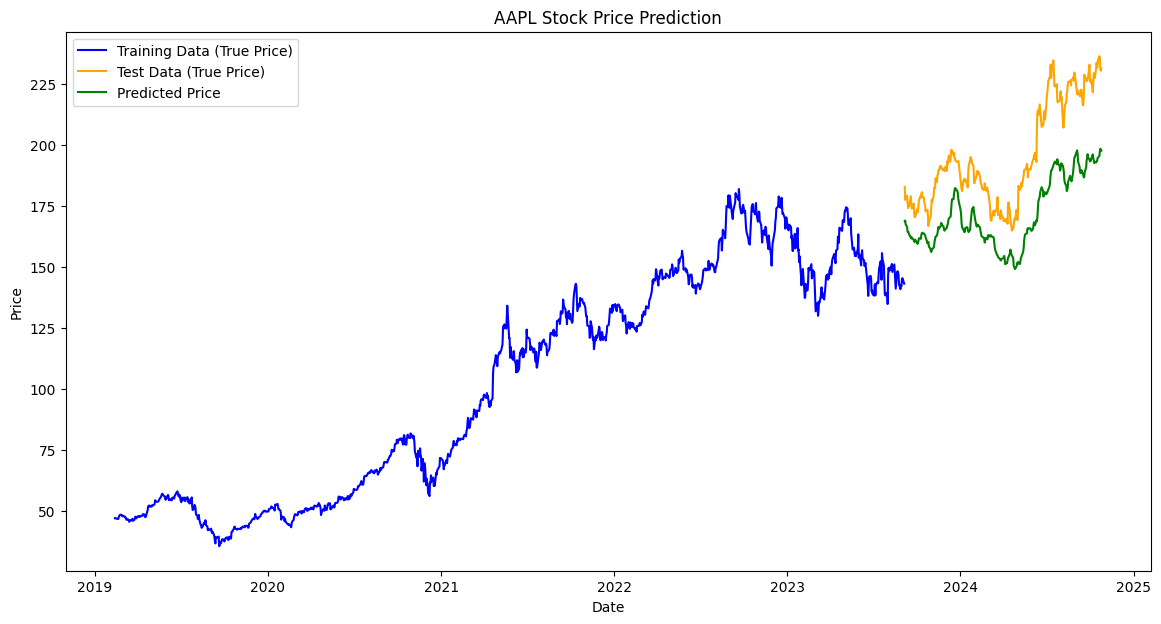

In [30]:
# Plot the results
plt.figure(figsize=(14, 7))
dates = df.index[look_back + forecast_horizon - 1:]
train_dates = dates[:train_size]
test_dates = dates[train_size:]

plt.plot(train_dates, scaler.inverse_transform(df_scaled[:train_size])[:, -1].reshape(-1, 1),
         label='Training Data (True Price)', color='blue')
plt.plot(test_dates, y_test_rescaled, label='Test Data (True Price)', color='orange')
plt.plot(test_dates, y_pred_rescaled, label='Predicted Price', color='green')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('AAPL Stock Price Prediction')
plt.legend()
plt.show()
